# Giải Puzzle 8 - Thuật toán A*

## Mô tả dự án
Dự án này triển khai thuật toán A* để giải bài toán 8-puzzle với các quy tắc đặc biệt:

### Quy tắc chơi:
1. **Quy tắc A + B = 9**: Có thể hoán đổi hai ô kề nhau (ngang hoặc dọc) nếu tổng của chúng bằng 9 (A, B ≠ 0)
2. **Quy tắc góc chéo**: Có thể hoán đổi hai ô ở góc chéo (không liên quan đến ô trống)

### Mục tiêu:
Tìm đường đi ngắn nhất từ trạng thái ban đầu đến một trong các trạng thái đích:
- `[[1,2,3],[4,5,6],[7,8,0]]` (mục tiêu chuẩn)
- `[[8,7,6],[5,4,3],[2,1,0]]` (mục tiêu ngược)
- `[[0,1,2],[3,4,5],[6,7,8]]` (mục tiêu hàng ngang)
- `[[0,8,7],[6,5,4],[3,2,1]]` (mục tiêu ngược hàng ngang)

### Thuật toán:
- **A\* Search** với hai heuristic:
  - **Misplaced Tiles**: Đếm số ô sai vị trí
  - **Break Point Distance**: Đếm số đoạn đứt gãy


## Chuẩn bị

Import các thư viện sử dụng xuyên suốt cả bài.


In [1]:
from typing import List, Tuple, Optional, Iterable
from copy import deepcopy
import heapq
from collections import deque, defaultdict
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
import numpy as np
import random

### Yêu cầu 1: Mô hình hóa không gian trạng thái

Các lớp bên dưới định nghĩa cấu hình, hành động, trạng thái, nút và bài toán 8-puzzle với những luật đặc thù.


In [2]:
class PuzzleConfig:
    GOAL_STATES = [
        [[1, 2, 3], [4, 5, 6], [7, 8, 0]],
        [[8, 7, 6], [5, 4, 3], [2, 1, 0]],
        [[0, 1, 2], [3, 4, 5], [6, 7, 8]],
        [[0, 8, 7], [6, 5, 4], [3, 2, 1]]
    ]


## Models Section

Các lớp cơ bản để biểu diễn trạng thái, hành động và nút trong cây tìm kiếm.


In [3]:
# Action Class
class Action:
    def __init__(self, action_type: str, pos1: Tuple[int, int], pos2: Tuple[int, int]):
        self.type = action_type
        self.pos1 = pos1
        self.pos2 = pos2

    def __str__(self):
        return f"{self.type}: {self.pos1} <-> {self.pos2}"

    def __repr__(self):
        return self.__str__()


In [4]:
# State Class
class State:
    def __init__(self, board: List[List[int]]):
        self.board = board
        self.blank_pos = self._find_blank()

    def _find_blank(self) -> Tuple[int, int]:
        for i in range(3):
            for j in range(3):
                if self.board[i][j] == 0:
                    return (i, j)
        return (0, 0)

    def get_valid_actions(self) -> List[Action]:
        actions = []

        # Original move UDLR
        blank = self.blank_pos
        if (blank[0] > 0):
            actions.append(Action("move_up", blank, (blank[0] - 1, blank[1])))
        if (blank[0] < 2):
            actions.append(Action("move_down", blank, (blank[0] + 1, blank[1])))
        if (blank[1] > 0):
            actions.append(Action("move_left", blank, (blank[0], blank[1] - 1)))
        if (blank[1] < 2):
            actions.append(Action("move_right", blank, (blank[0], blank[1] + 1)))

        # Rule 1: Swap A + B = 9
        for i in range(3):
            for j in range(3):
                if self.board[i][j] == 0:
                    continue

                # Check right neighbor
                if j < 2:
                    neighbor = self.board[i][j+1]
                    if neighbor != 0 and self.board[i][j] + neighbor == 9:
                        actions.append(Action("sum9_swap", (i, j), (i, j+1)))

                # Check bottom neighbor
                if i < 2:
                    neighbor = self.board[i+1][j]
                    if neighbor != 0 and self.board[i][j] + neighbor == 9:
                        actions.append(Action("sum9_swap", (i, j), (i+1, j)))

        # Rule 2: Corner diagonal swaps
        if self.board[0][0] != 0 and self.board[2][2] != 0:
            actions.append(Action("corner_swap", (0, 0), (2, 2)))

        if self.board[0][2] != 0 and self.board[2][0] != 0:
            actions.append(Action("corner_swap", (0, 2), (2, 0)))

        return actions

    def apply_action(self, action: Action) -> 'State':
        new_board = deepcopy(self.board)
        (r1, c1), (r2, c2) = action.pos1, action.pos2
        new_board[r1][c1], new_board[r2][c2] = new_board[r2][c2], new_board[r1][c1]
        return State(new_board)

    def to_tuple(self) -> Tuple:
        return tuple(tuple(row) for row in self.board)

    def __eq__(self, other):
        return self.board == other.board

    def __hash__(self):
        return hash(self.to_tuple())

    def __str__(self):
        result = "\n"
        for row in self.board:
            result += " ".join(str(x) if x != 0 else "_" for x in row) + "\n"
        return result


In [5]:
# Node Class
class Node:
    def __init__(self, state: State, parent: Optional['Node'],
                 action: Optional[Action], path_cost: int, heuristic: int):
        self.state = state
        self.parent = parent
        self.action = action
        self.path_cost = path_cost  # g(n)
        self.heuristic = heuristic  # h(n)
        self.f_score = path_cost + heuristic  # f(n) = g(n) + h(n)

    def get_path(self) -> List[Action]:
        path = []
        current = self
        while current.parent is not None:
            path.append(current.action)
            current = current.parent
        return list(reversed(path))

    def __lt__(self, other):
        return self.f_score < other.f_score


In [6]:
# Problem Class
class Problem:
    def __init__(self, initial_state: State, goal_states: List[List[List[int]]] = None):
        self.initial_state = initial_state

        if goal_states is None:
            goal_states = PuzzleConfig.GOAL_STATES

        self.goal_states = [State(goal) for goal in goal_states]

    def is_goal(self, state: State) -> bool:
        for goal in self.goal_states:
            if state.board == goal.board:
                return True
        return False

    def get_successors(self, state: State) -> List[Tuple[State, Action, int]]:
        successors = []

        actions = state.get_valid_actions()

        for action in actions:
            next_state = state.apply_action(action)
            cost = 1
            successors.append((next_state, action, cost))

        return successors


### Yêu cầu 2: Thuật toán A* và hai heuristic

Cài đặt hai heuristic (Misplaced Tiles, Break Point) và bộ giải A* cho bài toán.


In [7]:
# Heuristic Functions
class Heuristic:
    def __init__(self, goal_states: List[State]):
        self.goal_states = goal_states

    def calculate(self, state: State) -> int:
        raise NotImplementedError

    def name(self) -> str:
        return self.__class__.__name__


class MisplacedTilesHeuristic(Heuristic):
    def calculate(self, state: State) -> int:
        min_misplaced = float('inf')

        for goal in self.goal_states:
            misplaced = 0
            for i in range(3):
                for j in range(3):
                    if state.board[i][j] != 0 and state.board[i][j] != goal.board[i][j]:
                        misplaced += 1
            min_misplaced = min(min_misplaced, misplaced)

        return int(min_misplaced)


class BreakPoint(Heuristic):
  def calculate(self, state: State) -> int:
    min_breakpoint = float('inf')

    for goal in self.goal_states:
      flat = [num for line in state.board for num in line]
      breakpoint = 0
      for k in range(len(flat) - 1):
        if abs(flat[k + 1] - flat[k]) != 1:
          breakpoint += 1
      min_breakpoint = min(min_breakpoint, breakpoint)

    return int(min_breakpoint)

class bfs(Heuristic):
  def calculate(self, state: State) -> int:
    return 0

In [8]:
class AStar:
    def __init__(self, problem: Problem, heuristic: Heuristic):
        self.problem = problem
        self.heuristic = heuristic

    def search(self) -> Tuple[Optional[List[Action]], int]:
        if self.problem.is_goal(self.problem.initial_state):
            return [], 0

        h = self.heuristic.calculate(self.problem.initial_state)
        initial_node = Node(self.problem.initial_state, None, None, 0, h)

        frontier = []
        heapq.heappush(frontier, initial_node)
        explored = set()
        frontier_states = {initial_node.state.to_tuple(): initial_node}
        max_frontier_size = 0

        while frontier:
            max_frontier_size = max(max_frontier_size, len(frontier))
            current_node = heapq.heappop(frontier)
            current_state_tuple = current_node.state.to_tuple()

            if current_state_tuple in frontier_states:
                del frontier_states[current_state_tuple]

            if self.problem.is_goal(current_node.state):
                return current_node.get_path(), current_node.path_cost, explored, max_frontier_size

            explored.add(current_state_tuple)

            for next_state, action, cost in self.problem.get_successors(current_node.state):
                next_state_tuple = next_state.to_tuple()

                if next_state_tuple in explored:
                    continue

                g = current_node.path_cost + cost
                h = self.heuristic.calculate(next_state)
                child_node = Node(next_state, current_node, action, g, h)

                if next_state_tuple in frontier_states:
                    existing_node = frontier_states[next_state_tuple]
                    if child_node.f_score < existing_node.f_score:
                        frontier_states[next_state_tuple] = child_node
                        heapq.heappush(frontier, child_node)
                else:
                    frontier_states[next_state_tuple] = child_node
                    heapq.heappush(frontier, child_node)

        # Nếu không tìm thấy đường đi
        return None,-1, explored, max_frontier_size


### Phân tích admissibility và consistency
# Heuristic description:
**- Misplaced Tiles Heuristic**: function would compare current state with all goals state. With each goal state, number misplaced is number of wrong positions from the goal state. Function return minimum Misplaced value of these goal states. (except 0).
  - Admissibility: with original rules (UDLR) we need at least 1 move to get 1 tile to correct position

                  [[1,2,7],
                  [4,5,6],
                  [3,8,0]]
                  h(n) = 2
                  h*(n) = 1
                  h(n) > h*(n)

    So that, in some case heuristic value have to larger than optimal value.

                  h(n) >= h*(n) - R
            with: R is reduce step by 2 extra rules
    => Not Admissibility
  - Consistency: we have formular for Consistency

                  h(n) <= c(n, n') + h(n')

    All cost = 1 so that

                  [[2,1,7],
                  [4,5,6],
                  [3,8,0]]
                  h(n) = 4
                  h(n') = 2
                  h(n) > 1 + h(n') <-> 4 > 1 + 2

    => Not Consistency


**- Break point Heuristic:** : function would compare current state with all goals state. With each goal state, number position that:

                  |x(n+1) - x(n)| != 1
Function return minimun value of 4 goal state.

  - Admission: in a move can be fix more than 1 break point, example

                  [1,2,3,4,5,6,7,0,8] -> 2 break points
                  [1,2,3,4,5,6,7,8,0] -> 0 break points
                  h(n) = 2 ; h*(n) = 1
    So that, in some cases, h(n) > h*(n).

    => Not Admissibility
  - Consistency: with cost of an action c(n, n') = 1, in case:

                  [1,2,3,4,5,6,7,0,8] -> 2 break points -> h(n) = 2
                  [1,2,3,4,5,6,7,8,0] -> 0 break points -> h(n') = 0
                  h(n) > c(n, n') + h(n') ~ 2 > 1 + 0         
    So that, in some case

                  h(n) > c(n, n') + h(n')
    => Not Consistency.
                  

Description class admiss_and_consistancy
- Class take h(n) and h*(n) value of successor from initial_state.

- is_admissibility: return True if all h(n) <= h*(n). Return False if any case h(n) > h*(n)

- is_consistancy: return True if all |h(n) - h(n')|


In [9]:
# the admissibility and consistancy of the two selected heuristic


class admiss_and_consistancy:
  def __init__(self, heuristics: Heuristic, current_state: Optional[State] = None):
      if current_state is not None:
        self.curent_state = current_state
        self.heuristic = heuristics
        self.hn = self.get_hn()
        self.hnstar = self.get_hnstar()
      else:
        self.curent_state = State(get_randoom_state())
        self.heuristic = heuristics
        self.hn = None
        self.hnstar = None

  def get_hn(self):
      next_actions = self.curent_state.get_valid_actions()
      gn_next_state = []
      for act in next_actions:
        next_state = self.curent_state.apply_action(act)
        heu_cost = self.heuristic.calculate(next_state)
        gn_next_state.append(heu_cost)
        # print(next_state)
        # print(heu_cost)
      return gn_next_state

  def get_hnstar(self):
      next_actions = self.curent_state.get_valid_actions()
      hnstar_next_state = []
      next_states = []

      for act in next_actions:
        next_states.append(self.curent_state.apply_action(act))


      for stt in next_states:
        astar = AStar(Problem(stt), bfs([State(i) for i in PuzzleConfig().GOAL_STATES]))
        path, cost, _, _ = astar.search()
        hnstar_next_state.append(cost)
      return hnstar_next_state

  def is_admissibility(self):
    hn = self.get_hn()
    hnstar = self.get_hnstar()
    for i in range(len(hn)):
      if hn[i] > hnstar[i]:
        return False
    return True

  def is_consistancy(self):
    h_curr = self.heuristic.calculate(self.curent_state)
    for act in self.curent_state.get_valid_actions():
        nxt = self.curent_state.apply_action(act)
        h_next = self.heuristic.calculate(nxt)
        action_cost = 1  # nếu cost khác, lấy từ act hoặc problem
        if h_curr > action_cost + h_next:
          print(self.curent_state)
          print(f"h(n): {h_curr}, h(n'): {h_next}")

          return False
    return True

# curent_state_random = State(get_randoom_state())
curent_state_random =  State([[1,2,6],
                          [5,4,3],
                           [7,0,8]])
curent_state_except_admmiss = State([[1,2,6],[5,4,3],[7,8,0]])
curent_state_except_consis = State([[0,2,1],[3,5,4],[6,7,8]])

ob_misplaced = admiss_and_consistancy(MisplacedTilesHeuristic([State(i) for i in PuzzleConfig().GOAL_STATES]), curent_state_random)
ob_breakpoint = admiss_and_consistancy(BreakPoint([State(i) for i in PuzzleConfig().GOAL_STATES]), curent_state_random)

print("A* with misplaced heuristic")
print(ob_misplaced.curent_state)
print("h(n): ", ob_misplaced.hn)
print("h*(n): ", ob_misplaced.hnstar)
print("is admissibility: ", ob_misplaced.is_admissibility())
print("is consistancy: ", ob_misplaced.is_consistancy())

print("\nA* with Mahattan distance heuristic")
print(ob_breakpoint.curent_state)
print("h(n): ", ob_breakpoint.hn)
print("h*(n): ", ob_breakpoint.hn)
print("is admissibility: ", ob_breakpoint.is_admissibility())
print("is consistancy: ", ob_breakpoint.is_consistancy())


print("\nExcept case ---------------------------")
ob_misplaced_except = admiss_and_consistancy(MisplacedTilesHeuristic([State(i) for i in PuzzleConfig().GOAL_STATES]), curent_state_except_admmiss)
ob_breakpoint_except = admiss_and_consistancy(BreakPoint([State(i) for i in PuzzleConfig().GOAL_STATES]), curent_state_except_admmiss)

print("\nA* with misplaced heuristic")
print(ob_misplaced_except.curent_state)
print("h(n): ", ob_misplaced_except.hn)
print("h*(n): ", ob_misplaced_except.hnstar)
print("is admissibility: ", ob_misplaced_except.is_admissibility())
print("is consistancy: ", ob_misplaced_except.is_consistancy())


ob_misplaced_except = admiss_and_consistancy(MisplacedTilesHeuristic([State(i) for i in PuzzleConfig().GOAL_STATES]), curent_state_except_consis)
ob_breakpoint_except = admiss_and_consistancy(BreakPoint([State(i) for i in PuzzleConfig().GOAL_STATES]), curent_state_except_consis)

print("\nA* with break point distance heuristic")
print(ob_breakpoint_except.curent_state)
print("h(n): ", ob_breakpoint_except.hn)
print("h*(n): ", ob_breakpoint_except.hnstar)
print("is admissibility: ", ob_breakpoint_except.is_admissibility())
print("is consistancy: ", ob_breakpoint_except.is_consistancy())


A* with misplaced heuristic

1 2 6
5 4 3
7 _ 8

h(n):  [5, 4, 4, 3, 3, 3, 5]
h*(n):  [4, 4, 2, 2, 2, 4, 4]
is admissibility:  False
is consistancy:  True

A* with Mahattan distance heuristic

1 2 6
5 4 3
7 _ 8

h(n):  [6, 3, 3, 4, 6, 4, 5]
h*(n):  [6, 3, 3, 4, 6, 4, 5]
is admissibility:  False
is consistancy:  True

Except case ---------------------------

A* with misplaced heuristic

1 2 6
5 4 3
7 8 _

h(n):  [4, 4, 2, 2, 5]
h*(n):  [3, 3, 1, 1, 3]
is admissibility:  False

1 2 6
5 4 3
7 8 _

h(n): 4, h(n'): 2
is consistancy:  False

A* with break point distance heuristic

_ 2 1
3 5 4
6 7 8

h(n):  [2, 4, 3, 2, 6]
h*(n):  [11, 13, 13, 13, 13]
is admissibility:  True

_ 2 1
3 5 4
6 7 8

h(n): 4, h(n'): 2
is consistancy:  False


Evaluate efficient of 2 heuristic & compare result with BFS

In [10]:
def print_board(state):
    print("\n".join([" ".join(map(str, row)) for row in state.board]))
    print()
def show_solution(initial_state, path):
    current_state = initial_state
    for i, action in enumerate(path, 1):
        current_state = current_state.apply_action(action)
        print(f"Bước {i}: {action}")
        print_board(current_state)

def solve_puzzle(board: List[List[int]], heuristics: list, test_name: str):
    problem = Problem(State(board))
    print(f"{test_name}\nTrạng thái ban đầu:")
    print_board(problem.initial_state)

    for H in heuristics:
        astar = AStar(problem, H(problem.goal_states))
        path, cost, _, _ = astar.search()
        if path:
            print(f"{H.__name__}: Tìm thấy lời giải, chi phí {cost} bước")
            show_solution(problem.initial_state, path)
        else:
            print(f"{H.__name__}: Không tìm thấy lời giải!")

In [11]:
heuristics = [MisplacedTilesHeuristic, BreakPoint]
solve_puzzle([[1,2,3],[5,4,6],[7,8,0]], heuristics, "Test Case 1 (Dễ)")
solve_puzzle([[1,2,6],[5,4,3],[7,8,0]], heuristics, "Test Case 2 (Trung bình)")
solve_puzzle([[2,1,7],[5,4,3],[6,0,8]], heuristics, "Test Case 3 (Khó)")

Test Case 1 (Dễ)
Trạng thái ban đầu:
1 2 3
5 4 6
7 8 0

MisplacedTilesHeuristic: Tìm thấy lời giải, chi phí 1 bước
Bước 1: sum9_swap: (1, 0) <-> (1, 1)
1 2 3
4 5 6
7 8 0

BreakPoint: Tìm thấy lời giải, chi phí 1 bước
Bước 1: sum9_swap: (1, 0) <-> (1, 1)
1 2 3
4 5 6
7 8 0

Test Case 2 (Trung bình)
Trạng thái ban đầu:
1 2 6
5 4 3
7 8 0

MisplacedTilesHeuristic: Tìm thấy lời giải, chi phí 2 bước
Bước 1: sum9_swap: (0, 2) <-> (1, 2)
1 2 3
5 4 6
7 8 0

Bước 2: sum9_swap: (1, 0) <-> (1, 1)
1 2 3
4 5 6
7 8 0

BreakPoint: Tìm thấy lời giải, chi phí 2 bước
Bước 1: sum9_swap: (0, 2) <-> (1, 2)
1 2 3
5 4 6
7 8 0

Bước 2: sum9_swap: (1, 0) <-> (1, 1)
1 2 3
4 5 6
7 8 0

Test Case 3 (Khó)
Trạng thái ban đầu:
2 1 7
5 4 3
6 0 8

MisplacedTilesHeuristic: Tìm thấy lời giải, chi phí 9 bước
Bước 1: corner_swap: (0, 0) <-> (2, 2)
8 1 7
5 4 3
6 0 2

Bước 2: move_right: (2, 1) <-> (2, 2)
8 1 7
5 4 3
6 2 0

Bước 3: sum9_swap: (0, 0) <-> (0, 1)
1 8 7
5 4 3
6 2 0

Bước 4: move_up: (2, 2) <-> (1, 2)
1 8 7
5 4 0


### Yêu cầu 3: Minh họa cây tìm kiếm

Hàm dưới đây dựng cây tìm kiếm giới hạn số nút hiển thị bằng tham số `max_nodes`.


In [12]:
problem = Problem(State([[1,2,3],
                          [4,5,6],
                           [7,0,8]]))
def _format_action_label(action: Action) -> str:
    """Create a short label (L/R/U/D/Diag) for the given action."""
    if action is None:
        return ""

    delta_row = action.pos2[0] - action.pos1[0]
    delta_col = action.pos2[1] - action.pos1[1]
    direction_map = {
        (0, 1): "R",
        (0, -1): "L",
        (1, 0): "D",
        (-1, 0): "U",
    }

    if action.type == "corner_swap":
        return "Diag"

    if action.type == "sum9_swap":
        return direction_map.get((delta_row, delta_col), action.type)

    return action.type


def illustrate_search_tree(
    problem: Problem,
    max_nodes: Optional[int] = 15,
    allowed_action_types: Optional[Iterable[str]] = None,
    stop_at_goal: bool = False,
):
    if max_nodes is not None and max_nodes < 1:
        raise ValueError("max_nodes must be at least 1 or None")

    allowed = set(allowed_action_types) if allowed_action_types else None

    queue_nodes = deque([(problem.initial_state, None, None, 0)])
    nodes = []
    edges = []
    seen = set()

    while queue_nodes and (max_nodes is None or len(nodes) < max_nodes):
        state, parent_id, action, depth = queue_nodes.popleft()
        key = state.to_tuple()
        if key in seen:
            continue

        node_id = len(nodes)
        nodes.append({"id": node_id, "state": state, "depth": depth})
        seen.add(key)

        if parent_id is not None:
            edges.append((parent_id, node_id, action))

        if stop_at_goal and problem.is_goal(state):
            break

        if max_nodes is not None and len(nodes) >= max_nodes:
            break

        for next_state, next_action, _ in problem.get_successors(state):
            if allowed and next_action.type not in allowed:
                continue
            queue_nodes.append((next_state, node_id, next_action, depth + 1))

    if not nodes:
        return

    depth_groups = defaultdict(list)
    for node in nodes:
        depth_groups[node["depth"]].append(node)

    positions = {}
    horizontal_spacing = 3.0
    vertical_spacing = 2.4
    for depth in sorted(depth_groups):
        group = depth_groups[depth]
        count = len(group)
        for idx, node in enumerate(group):
            x = (idx - (count - 1) / 2) * horizontal_spacing
            y = -depth * vertical_spacing
            positions[node["id"]] = (x, y)

    max_nodes_per_depth = max(len(group) for group in depth_groups.values())
    figure_width = max(7, horizontal_spacing * max_nodes_per_depth + 3)
    figure_height = max(5, vertical_spacing * len(depth_groups) + 2)
    fig, ax = plt.subplots(figsize=(figure_width, figure_height))

    ellipse_width = 2.2
    ellipse_height = 1.0

    for parent_id, child_id, action in edges:
        x_parent, y_parent = positions[parent_id]
        x_child, y_child = positions[child_id]
        ax.annotate(
            "",
            xy=(x_child, y_child + ellipse_height / 2),
            xytext=(x_parent, y_parent - ellipse_height / 2),
            arrowprops={"arrowstyle": "->", "lw": 1.0},
        )
        label_x = (x_parent + x_child) / 2
        label_y = (y_parent + y_child) / 2
        ax.text(
            label_x,
            label_y,
            _format_action_label(action),
            ha="center",
            va="center",
            fontsize=10,
            bbox={"boxstyle": "round,pad=0.2", "facecolor": "white", "alpha": 0.7, "edgecolor": "none"},
        )

    for node in nodes:
        x, y = positions[node["id"]]
        ellipse = Ellipse((x, y), width=ellipse_width, height=ellipse_height, fill=False, linewidth=1.2)
        ax.add_patch(ellipse)
        ax.text(
            x,
            y,
            str(node["state"]),
            ha="center",
            va="center",
            fontsize=10,
            fontfamily="monospace",
            linespacing=1.15,
        )

    ax.set_title(f"Search tree (first {len(nodes)} nodes)", fontsize=14)
    ax.set_axis_off()

    xs = [pos[0] for pos in positions.values()]
    ys = [pos[1] for pos in positions.values()]
    ax.set_xlim(min(xs) - horizontal_spacing, max(xs) + horizontal_spacing)
    ax.set_ylim(min(ys) - vertical_spacing, max(ys) + vertical_spacing)

    plt.tight_layout()
    plt.show()


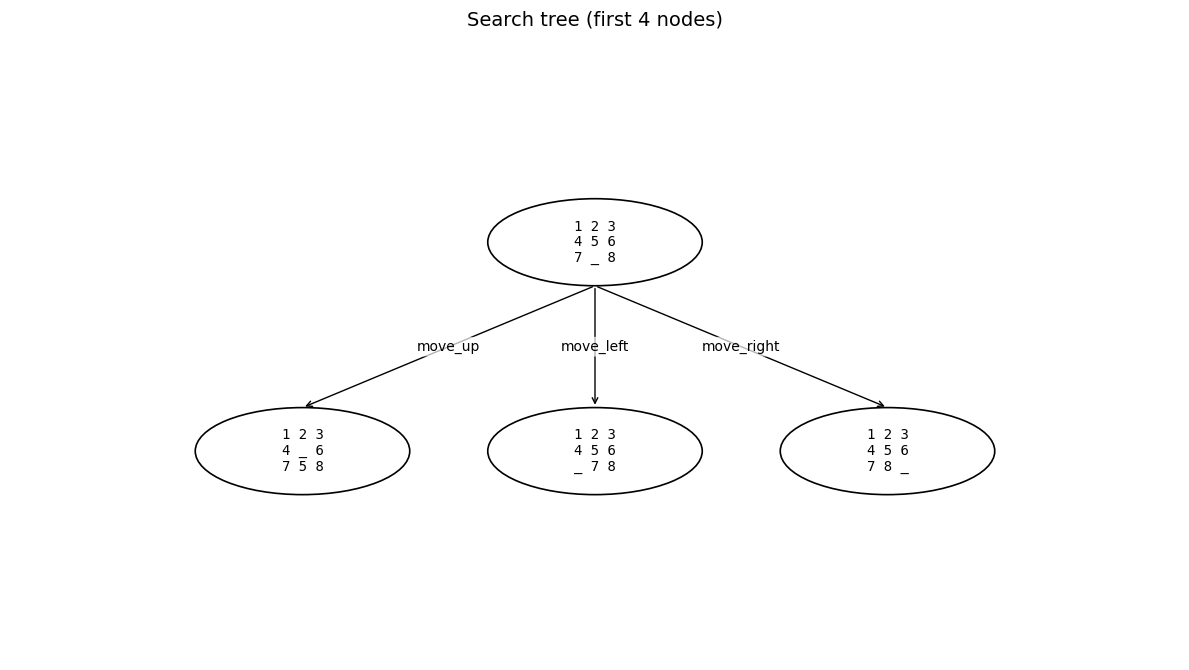

In [13]:
illustrate_search_tree(problem, max_nodes=25, stop_at_goal=True)

### Yêu cầu 4: Thí nghiệm đánh giá hiệu quả heuristic

Sinh ngẫu nhiên nhiều trạng thái ban đầu, chạy A* với từng heuristic và thống kê chi phí cũng như số nút đã mở rộng để so sánh trung bình.


**The average path cost  of the solution**


Problem: 
3 4 7
8 _ 5
6 2 1

Misplaced cost: 9
Breakpoint cost: 9

Problem: 
1 8 5
7 2 6
_ 4 3

Misplaced cost: 14
Breakpoint cost: 14

Problem: 
1 8 4
7 5 _
3 6 2

Misplaced cost: 15
Breakpoint cost: 15

Problem: 
5 1 8
7 6 3
2 _ 4

Misplaced cost: 14
Breakpoint cost: 14

Problem: 
8 3 4
5 2 6
7 _ 1

Misplaced cost: 9
Breakpoint cost: 9
List cost of A* using Misplaced:  [9, 14, 15, 14, 9]
List cost of A* using Breakpoint:  [9, 14, 15, 14, 9]
Averange A* using Misplaced:  12.2
Averange A* using Breakpoint:  12.2


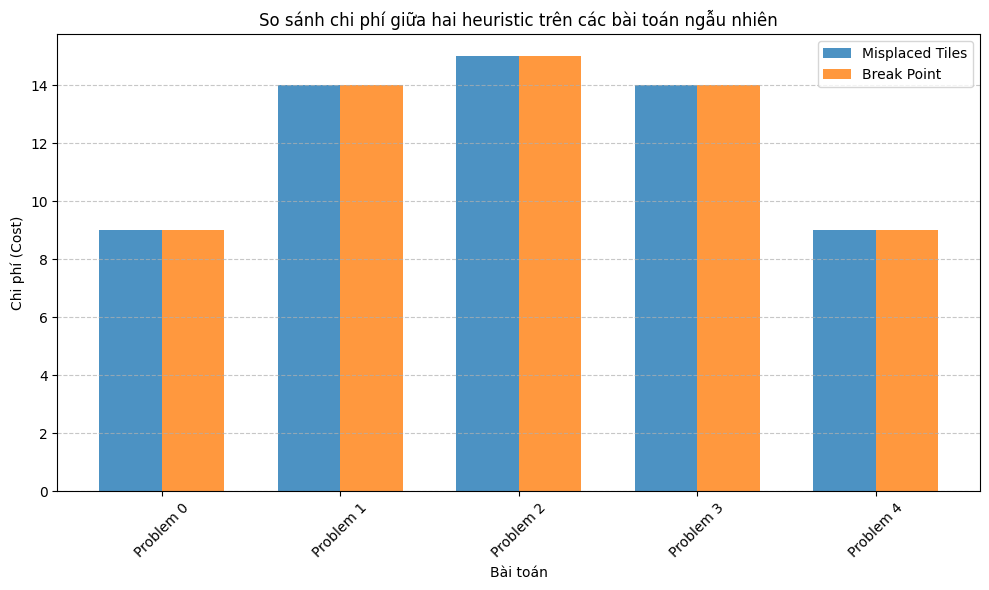

In [14]:
import matplotlib.pyplot as plt
import numpy as np

def get_randoom_state():
    state = [i for i in range(9)]
    random.shuffle(state)
    # Chuyển thành ma trận 3x3
    matrix = [state[i:i+3] for i in range(0, 9, 3)]
    return matrix

list_random_problem = [Problem(State(get_randoom_state())) for i in range(5)]
x_axis = ["Problem " + str(i) for i in range(len(list_random_problem))]

# Danh sách lưu kết quả cost
costs_misplaced = []
costs_breakpoint = []

# Lặp qua từng bài toán ngẫu nhiên
for prb in list_random_problem:
    astar_misplaced = AStar(prb, MisplacedTilesHeuristic([State(i) for i in PuzzleConfig().GOAL_STATES]))
    astar_breakpoint = AStar(prb, BreakPoint([State(i) for i in PuzzleConfig().GOAL_STATES]))  # 👈 khác heuristic
    path_mis, cost_mis, _, _ = astar_misplaced.search()
    path_break, cost_break, _, _ = astar_breakpoint.search()

    costs_misplaced.append(cost_mis)
    costs_breakpoint.append(cost_break)

    print("\nProblem:", prb.initial_state)
    print("Misplaced cost:", cost_mis)
    print("Breakpoint cost:", cost_break)

print("List cost of A* using Misplaced: ", costs_misplaced)
print("List cost of A* using Breakpoint: ", costs_breakpoint)
print("Averange A* using Misplaced: ", np.mean(costs_misplaced))
print("Averange A* using Breakpoint: ", np.mean(costs_breakpoint))

# Chuẩn bị dữ liệu trục x
x_axis = [f"Problem " + str(i) for i in range(len(list_random_problem))]
x = np.arange(len(x_axis))  # vị trí cột
width = 0.35  # độ rộng mỗi cột

# Vẽ biểu đồ cột
plt.figure(figsize=(10, 6))
plt.bar(x - width/2, costs_misplaced, width, label='Misplaced Tiles', alpha=0.8)
plt.bar(x + width/2, costs_breakpoint, width, label='Break Point', alpha=0.8)

# Trang trí biểu đồ
plt.title('So sánh chi phí giữa hai heuristic trên các bài toán ngẫu nhiên')
plt.xlabel('Bài toán')
plt.ylabel('Chi phí (Cost)')
plt.xticks(x, x_axis, rotation=45)
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()

# Hiển thị
plt.show()


### Yêu cầu 5+6: Tổ chức chương trình theo OOP và triển khai tổng quát
- **Action** định nghĩa thao tác hợp lệ (loại hành động và hai vị trí hoán đổi).
- **State** bao bọc trạng thái bàn cờ, cung cấp các phép sinh hành động hợp lệ, áp dụng hành động, so sánh và băm.
- **Node** lưu thông tin nút trên cây tìm kiếm (state, cha, action, chi phí, heuristic) và dựng lại lời giải.
- **Problem** trừu tượng hóa bài toán: giữ trạng thái đầu, tập đích, hàm kiểm tra goal và sinh kế thừa.
- **Heuristic** là lớp cơ sở; `MisplacedTilesHeuristic` và `BreakPoint` kế thừa và hiện thực `calculate`.
- **AStar** là lớp giải thuật nhận `Problem` và `Heuristic`, đóng gói toàn bộ logic tìm kiếm.

---



### Yêu cầu 7: Sơ Đồ Lớp
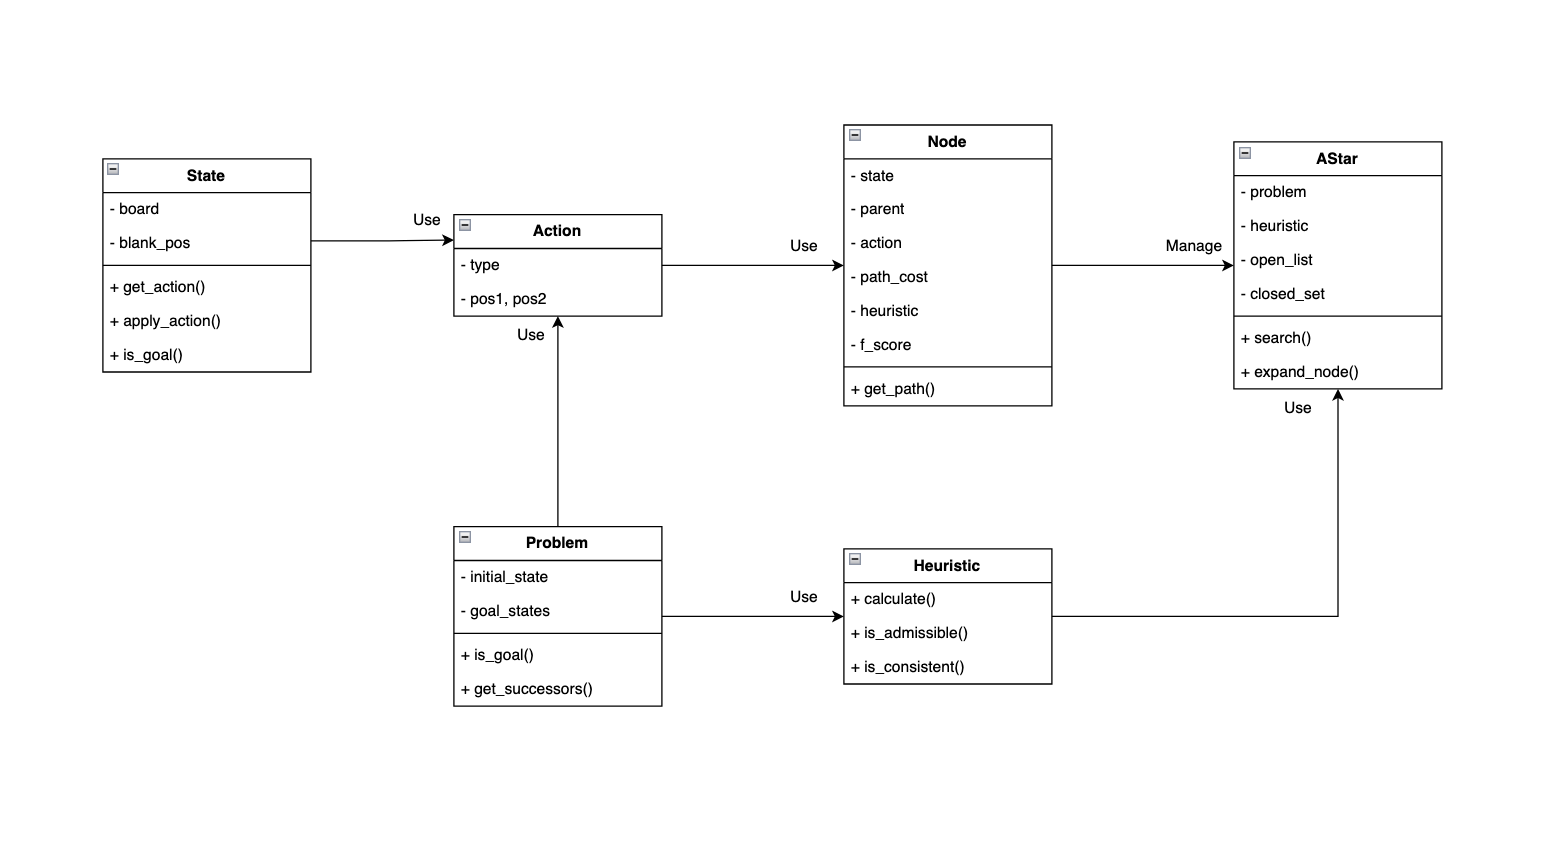


### Yêu cầu 8: So sánh thời gian và không gian

Đo lường số nút duyệt và kích thước hàng đợi tối đa của BFS và A* với hai heuristic, đồng thời trực quan hóa bằng biểu đồ.


BFS
Time complexity:  16
Space complexity:  42

Misplaced
Time complexity:  2
Space complexity:  8

Break point
Time complexity:  2
Space complexity:  8


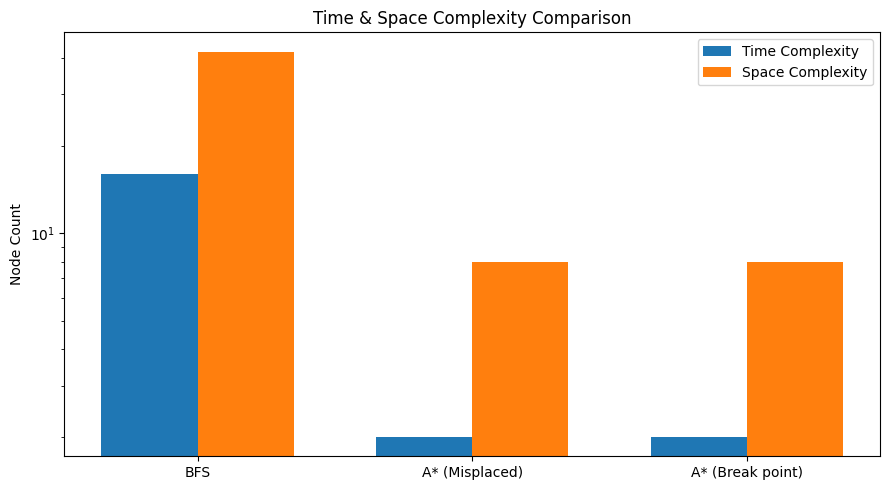

In [15]:
# problem = Problem(State([[1,2,3],
#                           [4,5,6],
#                            [7,0,8]]))
problem = Problem(State([[1,2,6],
                          [5,4,3],
                           [7,8,0]]))
# problem = Problem(State(get_randoom_state()))
# problem = Problem(curent_state_random)

ob_bfs = AStar(problem, bfs([State(i) for i in PuzzleConfig().GOAL_STATES]))
ob_misplaced = AStar(problem, MisplacedTilesHeuristic([State(i) for i in PuzzleConfig().GOAL_STATES]))
ob_breakpoint = AStar(problem, BreakPoint([State(i) for i in PuzzleConfig().GOAL_STATES]))

_, _, explored_bfs, frotier_bfs = ob_bfs.search()
_, _, explored_misplaced, frotier_misplaced = ob_misplaced.search()
_, _, explored_breakpoint, frotier_breakpoint = ob_breakpoint.search()

print("BFS")
print("Time complexity: ", len(explored_bfs))
print("Space complexity: ", frotier_bfs)

print("\nMisplaced")
print("Time complexity: ", len(explored_misplaced))
print("Space complexity: ", frotier_misplaced)

print("\nBreak point")
print("Time complexity: ", len(explored_breakpoint))
print("Space complexity: ", frotier_breakpoint)


time_complexities = {
    "BFS": len(explored_bfs),
    "A* (Misplaced)": len(explored_misplaced),
    "A* (Break point)": len(explored_breakpoint)
}

space_complexities = {
    "BFS": frotier_bfs,
    "A* (Misplaced)": frotier_misplaced,
    "A* (Break point)": frotier_breakpoint
}

# ====== VẼ BIỂU ĐỒ ======
labels = list(time_complexities.keys())
time_values = list(time_complexities.values())
space_values = list(space_complexities.values())

x = np.arange(len(labels))  # vị trí các nhóm trên trục X
width = 0.35  # độ rộng mỗi cột

fig, ax = plt.subplots(figsize=(9, 5))

# Cột Time (màu xanh)
bars_time = ax.bar(x - width/2, time_values, width, label='Time Complexity', color='#1f77b4')

# Cột Space (màu cam)
bars_space = ax.bar(x + width/2, space_values, width, label='Space Complexity', color='#ff7f0e')

# Thêm nhãn và tiêu đề
ax.set_ylabel('Node Count')
ax.set_title('Time & Space Complexity Comparison')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

ax.set_yscale('log')
plt.tight_layout()
plt.show()